In [ ]:
!pip install -U d2l

     |████████████████████████████████| 83 kB 1.3 MB/s 


## Assignment 2 - Image Classification
In this assignment, you will practice on image classification using CIFAR-10 dataset.
The codes for data downloading and processing are provided below. Note the train dataset is further split into train_ds and val_ds and three dataloaders (i.e., train_loader, val_loader, and test_loader) are created for training, validation, and testing, respectively.

You will need to complete the following tasks:

(1) Code the MnasNet-A1 (shown below, ref: https://arxiv.org/abs/1807.11626) in PyTorch by following the similar coding style as the examples shown in "NB6_ModernCNNs.ipynb". Specifically, you will need to "modularize" your codes, i.e., define proper "classes" and/or "functions" for different blocks as shown in Figure 7 below (e.g., MBConv3, MBConv6, and SepConv) and then use them to construct your model architecture.

(2) Train the MnasNet-A1 using CIFAR-10.

(3) Evaluate your model and report performance on the test dataset.


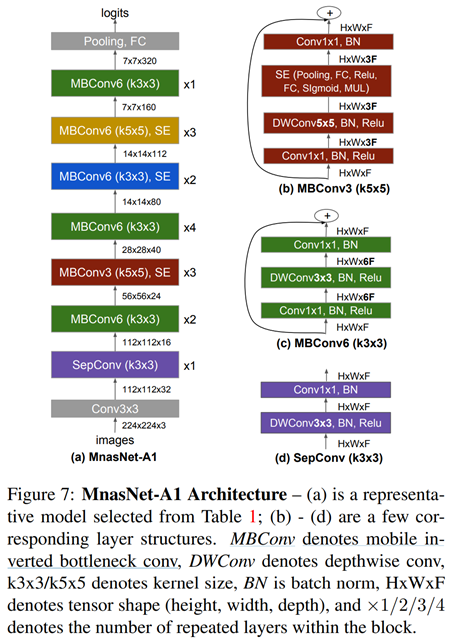

### Download datasets and create dataloaders

In [ ]:
import torch
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

cf10_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    normalize
])

train = CIFAR10(root='./data', train=True, download=True, transform=cf10_transforms)
test = CIFAR10(root='./data', train=False, download=True, transform=cf10_transforms)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
torch.manual_seed(42)
val_size = 5000
train_size = len(train) - val_size

In [ ]:
train_ds, val_ds = random_split(train, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [ ]:
batch_size=64

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 64, 64])


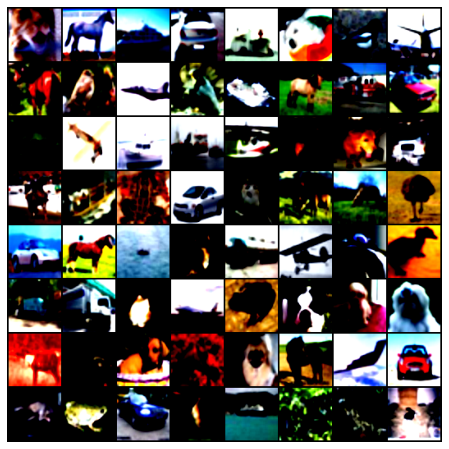

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

## Your codes go here:
### (1) Define the model

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

#Define SepConv Block
def SepConv(in_channels, out_channels, kernel_size=3, strides=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, groups=in_channels, padding=1),
        nn.BatchNorm2d(in_channels), 
        nn.ReLU(), 
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, groups=1, padding=0),
        nn.BatchNorm2d(out_channels))
    
#Define the SE Block
class SE_block(nn.Module):
    def __init__(self, c, r=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(c, c//r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c//r, c, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        bs, c, _, _ = x.shape
        y = self.squeeze(x).view(bs, c)
        y = self.excitation(y).view(bs, c, 1, 1)
        return x * y.expand_as(x)  

#Define MBConv6k33 Module/Block
class MBConv6k33(nn.Module):
    def __init__(self, input_channels, num_channels, strides=1, First=False):
        super().__init__()
        if First:
            self.conv1 = nn.Conv2d(input_channels, 6*input_channels, kernel_size=1, padding=0, stride=1,groups=1)
            self.conv2 = nn.Conv2d(6*input_channels, 6*input_channels, kernel_size=3, stride=2, groups=6*input_channels, padding=1)
            self.conv3 = nn.Conv2d(6*input_channels, num_channels,kernel_size=1, stride=1, groups=1, padding=0)
            self.bn1 = nn.BatchNorm2d(6*input_channels)
            self.bn2 = nn.BatchNorm2d(num_channels)
            self.skip = False
        else:
            self.conv1 = nn.Conv2d(input_channels, 6*input_channels, kernel_size=1, padding=0, stride=1,groups=1)
            self.conv2 = nn.Conv2d(6*input_channels, 6*input_channels, kernel_size=3, stride=1, groups=6*input_channels, padding=1)
            self.conv3 = nn.Conv2d(6*input_channels, input_channels,kernel_size=1, stride=1, groups=1, padding=0)
            self.bn1 = nn.BatchNorm2d(6*input_channels)
            self.bn2 = nn.BatchNorm2d(input_channels)
            self.skip = True
    def forward(self, X):
        XX = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn1(self.conv2(XX)))
        Y = self.bn2(self.conv3(Y))
        if self.skip:
            Y += X
        return Y

#Define MBConv6k333 Module/Block
class MBConv6k333(nn.Module):
    def __init__(self, input_channels, num_channels, strides=1, First=False):
        super().__init__()
        if First:
            self.conv1 = nn.Conv2d(input_channels, 6*input_channels, kernel_size=1, padding=0, stride=1,groups=1)
            self.conv2 = nn.Conv2d(6*input_channels, 6*input_channels, kernel_size=3, stride=1, groups=6*input_channels, padding=1)
            self.conv3 = nn.Conv2d(6*input_channels, num_channels,kernel_size=1, stride=1, groups=1, padding=0)
            self.bn1 = nn.BatchNorm2d(6*input_channels)
            self.bn2 = nn.BatchNorm2d(num_channels)
            self.skip = False
        else:
            self.conv1 = nn.Conv2d(input_channels, 6*input_channels, kernel_size=1, padding=0, stride=1,groups=1)
            self.conv2 = nn.Conv2d(6*input_channels, 6*input_channels, kernel_size=3, stride=1, groups=6*input_channels, padding=1)
            self.conv3 = nn.Conv2d(6*input_channels, input_channels,kernel_size=1, stride=1, groups=1, padding=0)
            self.bn1 = nn.BatchNorm2d(6*input_channels)
            self.bn2 = nn.BatchNorm2d(input_channels)
            self.skip = True
    def forward(self, X):
        XX = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn1(self.conv2(XX)))
        Y = self.bn2(self.conv3(Y))
        if self.skip:
            Y += X
        return Y

#Define MBConv6k55 Module/Block
class MBConv6k55(nn.Module):
    def __init__(self, input_channels, num_channels, strides=1,First=False):
        super().__init__()
        if First:
            self.conv1 = nn.Conv2d(input_channels, 6*input_channels, kernel_size=1, groups=1, padding=0, stride=1)
            self.conv2 = nn.Conv2d(6*input_channels, 6*input_channels, kernel_size=5, groups=6*input_channels, stride=2, padding=2)
            self.conv3 = nn.Conv2d(6*input_channels, num_channels,kernel_size=1, stride=1, groups=1, padding=0)
            self.bn1 = nn.BatchNorm2d(6*input_channels)
            self.bn2 = nn.BatchNorm2d(num_channels)
            self.skip = False
        else:
            self.conv1 = nn.Conv2d(input_channels, 6*input_channels, kernel_size=1, groups=1, padding=0, stride=1)
            self.conv2 = nn.Conv2d(6*input_channels, 6*input_channels, kernel_size=5, groups=6*input_channels, stride=1, padding=2)
            self.conv3 = nn.Conv2d(6*input_channels, input_channels,kernel_size=1, stride=1, groups=1, padding=0)
            self.bn1 = nn.BatchNorm2d(6*input_channels)
            self.bn2 = nn.BatchNorm2d(input_channels)
            self.skip = True
    def forward(self, X):
        XX = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn1(self.conv2(XX)))
        Y = self.bn2(self.conv3(Y))
        if self.skip:
            Y += X
        return Y

#Define MBConv3k55 Module/Block
class MBConv3k55(nn.Module):
    def __init__(self, input_channels, num_channels, strides=1, First=False):
        super().__init__()
        if First:
            self.conv1 = nn.Conv2d(input_channels, 3*input_channels, kernel_size=1, padding=0, stride=1,groups=1)
            self.conv2 = nn.Conv2d(3*input_channels, 3*input_channels, kernel_size=5, stride=2, groups=3*input_channels, padding=2)
            self.conv3 = nn.Conv2d(3*input_channels, num_channels,kernel_size=1, padding=0, stride=1, groups=1)
            self.bn1 = nn.BatchNorm2d(3*input_channels)
            self.bn2 = nn.BatchNorm2d(num_channels)
            self.se = SE_block(3*input_channels)
            self.skip=False
        else:
            self.conv1 = nn.Conv2d(input_channels, 3*input_channels, kernel_size=1, padding=0, stride=1,groups=1)
            self.conv2 = nn.Conv2d(3*input_channels, 3*input_channels, kernel_size=5, stride=1, groups=3*input_channels, padding=2)
            self.conv3 = nn.Conv2d(3*input_channels, input_channels,kernel_size=1, padding=0, stride=1, groups=1)
            self.bn1 = nn.BatchNorm2d(3*input_channels)
            self.bn2 = nn.BatchNorm2d(input_channels)
            self.se = SE_block(3*input_channels)
            self.skip=True

    def forward(self, X):
        XX = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn1(self.conv2(XX)))
        Y = self.se(Y)
        Y = self.bn2(self.conv3(Y))
        if self.skip:
            Y += X
        return Y

#Define MBConv6k33_SE Module/Block
class MBConv6k33_SE(nn.Module):
    def __init__(self, input_channels, num_channels, strides=1, First=False):
        super().__init__()
        if First:
            self.conv1 = nn.Conv2d(input_channels, 6*input_channels, kernel_size=1, padding=0, stride=1,groups=1)
            self.conv2 = nn.Conv2d(6*input_channels, 6*input_channels, kernel_size=3, stride=1, groups=6*input_channels, padding=1)
            self.conv3 = nn.Conv2d(6*input_channels, num_channels,kernel_size=1, stride=1, groups=1, padding=0)
            self.bn1 = nn.BatchNorm2d(6*input_channels)
            self.bn2 = nn.BatchNorm2d(num_channels)
            self.se = SE_block(num_channels)
            self.skip = False
        else:
            self.conv1 = nn.Conv2d(input_channels, 6*input_channels, kernel_size=1, padding=0, stride=1,groups=1)
            self.conv2 = nn.Conv2d(6*input_channels, 6*input_channels, kernel_size=3, stride=1, groups=6*input_channels, padding=1)
            self.conv3 = nn.Conv2d(6*input_channels, input_channels,kernel_size=1, stride=1, groups=1, padding=0)
            self.bn1 = nn.BatchNorm2d(6*input_channels)
            self.bn2 = nn.BatchNorm2d(input_channels)
            self.se = SE_block(input_channels)
            self.skip = True
    def forward(self, X):
        XX = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn1(self.conv2(XX)))
        Y = self.bn2(self.conv3(Y))
        if self.skip:
            Y += X
        Y=self.se(Y)
        return Y

#Define MBConv3k55_SE Module/Block
class MBConv3k55_SE(nn.Module):
    def __init__(self, input_channels, num_channels, strides=1, First=False):
        super().__init__()
        if First:
            self.conv1 = nn.Conv2d(input_channels, 3*input_channels, kernel_size=1, padding=0, stride=1,groups=1)
            self.conv2 = nn.Conv2d(3*input_channels, 3*input_channels, kernel_size=5, stride=2, groups=3*input_channels, padding=2) #3
            self.conv3 = nn.Conv2d(3*input_channels, num_channels,kernel_size=1, padding=0, stride=1, groups=1)
            self.bn1 = nn.BatchNorm2d(3*input_channels) #3
            self.bn2 = nn.BatchNorm2d(num_channels)
            self.se1 = SE_block(3*input_channels) #3
            self.se2 = SE_block(num_channels)
            self.skip=False
        else:
            self.conv1 = nn.Conv2d(input_channels, 3*input_channels, kernel_size=1, padding=0, stride=1,groups=1)
            self.conv2 = nn.Conv2d(3*input_channels, 3*input_channels, kernel_size=5, stride=1, groups=3*input_channels, padding=2) #3
            self.conv3 = nn.Conv2d(3*input_channels, input_channels,kernel_size=1, padding=0, stride=1, groups=1)
            self.bn1 = nn.BatchNorm2d(3*input_channels) #3
            self.bn2 = nn.BatchNorm2d(input_channels)
            self.se1 = SE_block(3*input_channels) #3
            self.se2 = SE_block(input_channels)
            self.skip=True

    def forward(self, X):
        XX = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn1(self.conv2(XX)))
        Y = self.se1(Y)
        Y = self.bn2(self.conv3(Y))
        if self.skip:
            Y += X
        Y = self.se2(Y)
        return Y

#Define MBConv6k55_SE Module/Block
class MBConv6k55_SE(nn.Module):
    def __init__(self, input_channels, num_channels, strides=1,First=False):
        super().__init__()
        if First:
            self.conv1 = nn.Conv2d(input_channels, 6*input_channels, kernel_size=1, groups=1, padding=0, stride=1)
            self.conv2 = nn.Conv2d(6*input_channels, 6*input_channels, kernel_size=5, groups=6*input_channels, stride=2, padding=2)
            self.conv3 = nn.Conv2d(6*input_channels, num_channels,kernel_size=1, stride=1, groups=1, padding=0)
            self.bn1 = nn.BatchNorm2d(6*input_channels)
            self.bn2 = nn.BatchNorm2d(num_channels)
            self.se = SE_block(num_channels)
            self.skip = False
        else:
            self.conv1 = nn.Conv2d(input_channels, 6*input_channels, kernel_size=1, groups=1, padding=0, stride=1)
            self.conv2 = nn.Conv2d(6*input_channels, 6*input_channels, kernel_size=5, groups=6*input_channels, stride=1, padding=2)
            self.conv3 = nn.Conv2d(6*input_channels, input_channels,kernel_size=1, stride=1, groups=1, padding=0)
            self.bn1 = nn.BatchNorm2d(6*input_channels)
            self.bn2 = nn.BatchNorm2d(input_channels)
            self.se = SE_block(input_channels)
            self.skip = True
    def forward(self, X):
        XX = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn1(self.conv2(XX)))
        Y = self.bn2(self.conv3(Y))
        if self.skip:
            Y += X
        Y=self.se(Y)
        return Y

#net = nn.Sequential(MBConv6k33_SE(112, 160, First=True))
net = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1,groups=1), # Conv3×3
                    SepConv(32, 16, kernel_size=3, strides=1, padding=1), # SepConv(k3×3) × 1
                    MBConv6k33(16, 24, First=True),MBConv6k33(24, 24),  # MBConv6(k3×3) × 2
                    MBConv3k55_SE(24, 40, First=True),MBConv3k55_SE(40, 40),MBConv3k55_SE(40, 40), # MBConv3(k5×5)SE × 3
                    MBConv6k33(40, 80, First=True),MBConv6k33(80, 80),MBConv6k33(80, 80),MBConv6k33(80, 80), # MBConv6(k3×3) × 4
                    MBConv6k33_SE(80, 112, First=True),MBConv6k33_SE(112, 112), # MBConv6(k3×3)SE × 2
                    MBConv6k55_SE(112, 160, First=True),MBConv6k55_SE(160, 160),MBConv6k55_SE(160, 160), # MBConv6(k5×5)SE × 3
                    MBConv6k333(160, 320, First=True),nn.ReLU(),  # MBConv6(k3×3) × 1
                    nn.Flatten(), nn.Linear(1280, 512), nn.ReLU(), nn.Linear(512, 10))  # Classifier

X = torch.rand(size=(1, 3, 64, 64))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 32, 32, 32])
Sequential output shape:	 torch.Size([1, 16, 32, 32])
MBConv6k33 output shape:	 torch.Size([1, 24, 16, 16])
MBConv6k33 output shape:	 torch.Size([1, 24, 16, 16])
MBConv3k55_SE output shape:	 torch.Size([1, 40, 8, 8])
MBConv3k55_SE output shape:	 torch.Size([1, 40, 8, 8])
MBConv3k55_SE output shape:	 torch.Size([1, 40, 8, 8])
MBConv6k33 output shape:	 torch.Size([1, 80, 4, 4])
MBConv6k33 output shape:	 torch.Size([1, 80, 4, 4])
MBConv6k33 output shape:	 torch.Size([1, 80, 4, 4])
MBConv6k33 output shape:	 torch.Size([1, 80, 4, 4])
MBConv6k33_SE output shape:	 torch.Size([1, 112, 4, 4])
MBConv6k33_SE output shape:	 torch.Size([1, 112, 4, 4])
MBConv6k55_SE output shape:	 torch.Size([1, 160, 2, 2])
MBConv6k55_SE output shape:	 torch.Size([1, 160, 2, 2])
MBConv6k55_SE output shape:	 torch.Size([1, 160, 2, 2])
MBConv6k333 output shape:	 torch.Size([1, 320, 2, 2])
ReLU output shape:	 torch.Size([1, 320, 2, 2])
Flatten output shape:	 torch.Size(

### (2) Train the model using train and val datasets

loss 1.540, train acc 0.393, valid acc 0.098
639.8 examples/sec on cuda:0


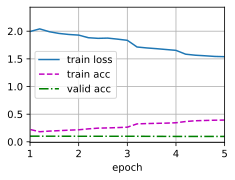

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None): 
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_validation(net, train_iter, valid_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'valid acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        valid_acc = evaluate_accuracy_gpu(net, valid_iter)
        animator.add(epoch + 1, (None, None, valid_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'valid acc {valid_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    
lr, num_epochs = 0.05, 5
train_validation(net, train_loader, val_loader, num_epochs, lr, d2l.try_gpu())
#lr, num_epochs = 0.2, 5
#d2l.train_ch6(net, train_loader, val_loader, num_epochs, lr, d2l.try_gpu())

### (3) Evaluate the model and report performance using the test dataset

In [ ]:
test_acc = evaluate_accuracy_gpu(net, test_loader)
print(f'test acc {test_acc:.3f}')

test acc 0.100
